---
title: Real or Not? NLP with Disaster Tweets: Practice Classifier
date: 2021-03-03


---

# About this Notebook
## This is classifier paractices on one of Kaggle probelms using machine learning methods
##  Real or Not? NLP with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not
https://www.kaggle.com/c/nlp-getting-started/leaderboard#score

For this compition we used Support Vector Machine to predict the target, we scored 0.75255 accuracy and number 1997 on the leaderboard. 

Content: 
* Load Librarys
* Load Data and data analysis 
* Model Selaction
    * Support Vector Machine
    * k-Nearest Neighbor
    * Decision tree
    * Naive Bayes Classifiers
    * Keras TensorFlow
* Submition 

# Load Librarys

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
from matplotlib import pyplot as plt

import requests
from contextlib import closing
import csv

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold , GridSearchCV
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Load Data 

In [3]:
train_df = pd.read_csv("/Users/mamo/Python_Project/train.csv")
test_df = pd.read_csv("/Users/mamo/Python_Project/test.csv")

In [4]:
print (train_df.shape, test_df.shape)

(7613, 5) (3263, 4)


In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [7]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

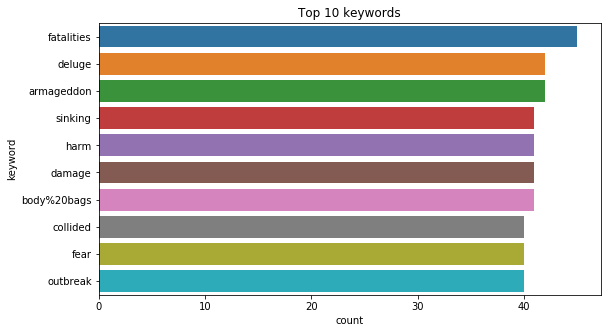

In [147]:
# Thanks to https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
# Most common "keywords"

plt.figure(figsize=(9,5))

sns.countplot(y=train_df.keyword, order = train_df.keyword.value_counts().iloc[:10].index)
plt.title('Top 10 keywords')
plt.show()

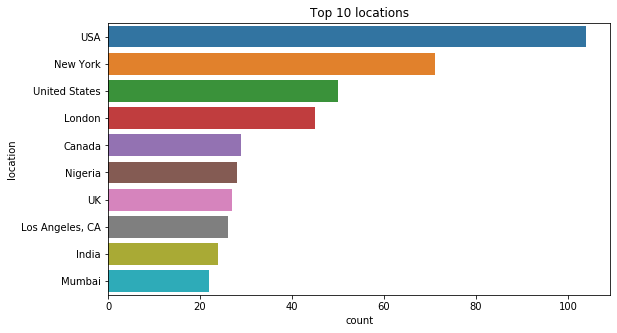

In [150]:
#thanks to https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
# Top 20 Locations

plt.figure(figsize=(9,5))
sns.countplot(y=train_df.location, order = train_df.location.value_counts().iloc[:10].index)

plt.title('Top 10 locations')
plt.show()

## Tokinize text 
Tokenization is a process that splits an input sequence into so-called tokens where the tokens can be a word, sentence, paragraph etc. Then transform text (tokens to a vector) into a meaningful vector (or array) of numbers. 

In [9]:
tokenizer = CountVectorizer()
train_vectors = tokenizer.fit_transform(train_df['text'])

In [10]:
## we use .todense() here because these vectors are "sparse" (only non-zero elements are kept to save space)
print(train_vectors[0].todense().shape)
print(train_vectors[0].todense())

(1, 21637)
[[0 0 0 ... 0 0 0]]



# Model Selaction
## Support Vector Machine

In [11]:
# Split traning set for tarning and testing
X_train, X_test, y_train, y_test = train_test_split(train_vectors, train_df["target"], test_size=0.30, random_state=42)

In [14]:
# Cross_Validation
kf = KFold(n_splits=5, random_state=1337, shuffle=True)
kf.get_n_splits(X_train) # returns the number of splitting iterations in the cross-validator
print(kf) 

KFold(n_splits=2, random_state=None, shuffle=False)


KFold(n_splits=2, random_state=None, shuffle=False)

In [13]:
# Thanks to https://www.kaggle.com/oldelephant/disaster-tweets-svm
# Hyperparameter tuning
parameters = { 
    'gamma': [0.001, 0.01, 0.1, 0.4, 0.5, 0.6, 0.7, 1], 
    'kernel': ['rbf'], 
    'C': [0.001, 0.01, 0.1, 1, 1.5, 2, 3, 10],
}
clf = GridSearchCV(SVC(), parameters, cv=10, n_jobs=-1).fit(X_train, y_train)

In [26]:
# Cross_Validation
scores = model_selection.cross_val_score(clf, train_vectors, train_df["target"], cv=3, scoring="f1")
scores

array([0.61341108, 0.57644394, 0.65988216])

In [28]:
# model accuracy on the test set
clf.score(X_test, y_test)

0.809106830122592

In [29]:
# Model perdictoin
test_vectors = tokenizer.transform(test_df['text'])
predictions = clf.predict(X_test)

In [30]:
accuracy_score(y_test, predictions)

0.809106830122592

In [31]:
# Confusion matrix
print(pd.crosstab(y_test, predictions, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted     0    1   All
True                      
0          1212  106  1318
1           330  636   966
All        1542  742  2284


## k-Nearest Neighbor

In [32]:
knn = KNeighborsClassifier(n_neighbors=3)

In [33]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [34]:
knn.score(X_test, y_test)

0.6882661996497373

In [35]:
predictions2= knn.predict(X_test)

In [36]:
accuracy_score(y_test, predictions2)

0.6882661996497373

In [37]:
print(pd.crosstab(y_test, predictions2, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted     0    1   All
True                      
0          1270   48  1318
1           664  302   966
All        1934  350  2284


## Decision tree

In [66]:
tree = DecisionTreeClassifier(random_state=1234)

In [67]:
scores = model_selection.cross_val_score(tree, train_vectors, train_df["target"], cv=5, scoring="f1")
scores

array([0.58218549, 0.48229342, 0.50958466, 0.56458512, 0.59665145])

In [68]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

In [69]:
tree.score(X_train, y_train)

0.9971852129855507

In [70]:
predictions3= tree.predict(X_test)

In [71]:
tree.score(X_test, y_test)

0.7197898423817863

In [72]:
accuracy_score(y_test, predictions3)

0.7197898423817863

In [73]:
# Confusion matrix
print(pd.crosstab(y_test, predictions3, rownames=['True'], colnames=['Predicted'], margins=True))

Predicted     0    1   All
True                      
0          1039  279  1318
1           361  605   966
All        1400  884  2284


##  Naive Bayes Classifiers

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

In [56]:
# Fitting a simple Naive Bayes on Counts
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train_df["target"], cv=5, scoring="f1")
scores

array([0.6507019 , 0.62611276, 0.69247626, 0.65555556, 0.74369748])

In [57]:
clf_NB.fit(train_vectors, train_df["target"])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [61]:
clf_NB.score(X_train, y_train)

0.9044848939763558

In [62]:
predictions4= tree.predict(X_test)

In [64]:
accuracy_score(y_test, predictions4)

0.7215411558669002

# Submit

In [21]:
sample_submission = pd.read_csv("sample_submission.csv")

In [22]:
sample_submission["target"] = clf.predict(test_vectors)

In [23]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1


In [24]:
sample_submission.to_csv("submission.csv", index=False)

## Keras TensorFlow

### Thanks to  https://www.kaggle.com/alexandrucodrescu/tweet-nlp-tensorflow-keras

In [151]:
# Import libraries

!pip install tensorflow
#!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from collections import defaultdict
import csv
import re
#from tabulate import tabulate
import tensorflow as tf
from tensorflow import keras
from tensorflow_core.python.keras.utils.data_utils import Sequence
from tensorflow.keras.utils import Sequence


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import SimpleRNN



In [80]:
import re

test_str = train_df.loc[417, 'text']

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text

print("Original text: " + test_str)
print("Cleaned text: " + clean_text(test_str))

Original text: Arson suspect linked to 30 fires caught in Northern California http://t.co/mmGsyAHDzb
Cleaned text: Arson suspect linked to 30 fires caught in Northern California


In [81]:
def find_hashtags(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"#\w+", tweet)]) or 'no'

def find_mentions(tweet):
    return " ".join([match.group(0)[1:] for match in re.finditer(r"@\w+", tweet)]) or 'no'

def find_links(tweet):
    return " ".join([match.group(0)[:] for match in re.finditer(r"https?://\S+", tweet)]) or 'no'

def process_text(df):
    
    df['text_clean'] = df['text'].apply(lambda x: clean_text(x))
    df['hashtags'] = df['text'].apply(lambda x: find_hashtags(x))
    df['mentions'] = df['text'].apply(lambda x: find_mentions(x))
    df['links'] = df['text'].apply(lambda x: find_links(x))
    # df['hashtags'].fillna(value='no', inplace=True)
    # df['mentions'].fillna(value='no', inplace=True)
    
    return df
    
train_df = process_text(train_df)
test_df = process_text(test_df)

In [82]:
train_df.head()

,id,keyword,location,text,target,text_clean,hashtags,mentions,links
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Alaska wildfires,no,no


In [83]:
cuvinte_text = []
for i in range(0,7613):
    cuvinte_text.append(train_df['text_clean'][i].split())

In [84]:
contor_cuvinte = defaultdict(int)

for doc in cuvinte_text:
    for word in doc:
        contor_cuvinte[word] += 1

PRIMELE_N_CUVINTE = 1000
        
# transformam dictionarul in lista de tupluri ['cuvant1', frecventa1, 'cuvant2': frecventa2]
perechi_cuvinte_frecventa = list(contor_cuvinte.items())

# sortam descrescator lista de tupluri dupa frecventa
perechi_cuvinte_frecventa = sorted(perechi_cuvinte_frecventa, key=lambda kv: kv[1], reverse=True)

# extragem primele 1000 cele mai frecvente cuvinte din toate textele
perechi_cuvinte_frecventa = perechi_cuvinte_frecventa[0:PRIMELE_N_CUVINTE]

print ("Primele 10 cele mai frecvente cuvinte ", perechi_cuvinte_frecventa[0:10])

Primele 10 cele mai frecvente cuvinte  [('the', 2575), ('a', 1845), ('to', 1805), ('in', 1757), ('of', 1722), ('and', 1302), ('I', 1197), ('for', 820), ('is', 814), ('on', 773)]


In [85]:
list_of_selected_words = []
for cuvant, frecventa in perechi_cuvinte_frecventa:
    list_of_selected_words.append(cuvant)
### numaram cuvintele din toate documentele ###

In [86]:
def get_bow(text, lista_de_cuvinte):
    '''
    returneaza BoW corespunzator unui text impartit in cuvinte
    in functie de lista de cuvinte selectate
    '''
    contor = dict()
    cuvinte = set(lista_de_cuvinte)
    for cuvant in cuvinte:
        contor[cuvant] = 0
    for cuvant in text:
        if cuvant in cuvinte:
            contor[cuvant] += 1
    return contor

In [87]:
def get_bow_pe_corpus(corpus, lista):
    '''
    returneaza BoW normalizat
    corespunzator pentru un intreg set de texte
    sub forma de matrice np.array
    '''
    bow = np.zeros((len(corpus), len(lista)))
    for idx, doc in enumerate(corpus):
        bow_dict = get_bow(doc, lista)
        ''' 
            bow e dictionar.
            bow.values() e un obiect de tipul dict_values 
            care contine valorile dictionarului
            trebuie convertit in lista apoi in numpy.array
        '''
        v = np.array(list(bow_dict.values()))
        #v = v / np.sqrt(np.sum(v ** 2))
        bow[idx] = v
    return bow

In [88]:
data_bow = get_bow_pe_corpus(cuvinte_text, list_of_selected_words)
print ("Data bow are shape: ", data_bow.shape)

Data bow are shape:  (7613, 1000)


In [89]:
train_df.head()

,id,keyword,location,text,target,text_clean,hashtags,mentions,links
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake M...,earthquake,no,no
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,no,no,no
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' are ...,no,no,no
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...",wildfires,no,no
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska as ...,Alaska wildfires,no,no


In [90]:
x_val = data_bow[:1000]
x_train = data_bow[1000:]

y_val = train_df['target'][:1000]
y_train = train_df['target'][1000:]

In [91]:
z_train = []
for i in range(1000,7613):
    z_train.append(y_train[i])

In [92]:
z_val = []
for i in range(0,1000):
    z_val.append(y_val[i])

In [93]:
z_train_array = np.asarray(z_train)
z_val_array = np.asarray(z_val)

In [126]:
model = keras.Sequential()

model.add(keras.layers.Dense(16,input_shape = (1000,), activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))


In [127]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [129]:
fitmodel = model.fit(x_train, z_train_array, epochs = 10, batch_size = 5121, validation_data = (x_val, z_val_array), verbose = 1)

Train on 6613 samples, validate on 1000 samples
Epoch 1/10
6613/6613 [==============================] - 0s 41us/sample - loss: 0.6004 - accuracy: 0.8315 - val_loss: 0.6788 - val_accuracy: 0.7940
Epoch 2/10
6613/6613 [==============================] - 0s 11us/sample - loss: 0.6004 - accuracy: 0.8320 - val_loss: 0.6789 - val_accuracy: 0.7940
Epoch 3/10
6613/6613 [==============================] - 0s 9us/sample - loss: 0.6003 - accuracy: 0.8318 - val_loss: 0.6789 - val_accuracy: 0.7940
Epoch 4/10
6613/6613 [==============================] - 0s 14us/sample - loss: 0.6002 - accuracy: 0.8321 - val_loss: 0.6788 - val_accuracy: 0.7930
Epoch 5/10
6613/6613 [==============================] - 0s 12us/sample - loss: 0.6001 - accuracy: 0.8325 - val_loss: 0.6788 - val_accuracy: 0.7930
Epoch 6/10
6613/6613 [==============================] - 0s 9us/sample - loss: 0.6001 - accuracy: 0.8325 - val_loss: 0.6788 - val_accuracy: 0.7930
Epoch 7/10
6613/6613 [==============================] - 0s 9us/sample - 

In [97]:
cuvinte_text_pred = []
for i in range(0,3263):
    cuvinte_text_pred.append(test_df['text'][i].split())

In [98]:
test_data = get_bow_pe_corpus(cuvinte_text_pred, list_of_selected_words)

In [99]:
predict = model.predict(test_data)

In [100]:
pred = []
for i in range (0,3263):
    pred.append(predict[i][0])

In [101]:
norm_pred = []
for i in range (0,3263):
    if pred[i] > 0.5:
        norm_pred.append(1)
    else:
        norm_pred.append(0)

In [102]:
submission = pd.DataFrame({
        "id": test_df["id"],
        "target": norm_pred
    })

In [103]:
submission.to_csv("submission.csv",index=False)

In [104]:
submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
